# Open AI gym example
This code shows the use of open AI with chaos theory

### Section 1
Creating the open AI gym simulation

In [1]:
import sys
import gym
import gym
from gym import logger as gymlogger
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

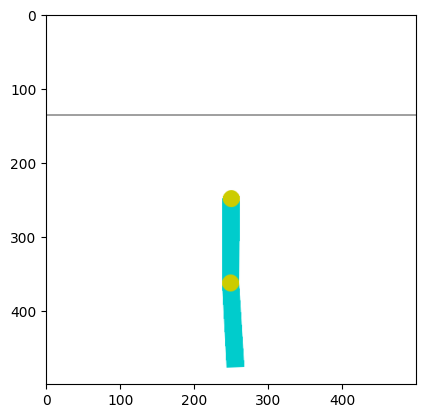

In [26]:
env = gym.make("Acrobot-v1",render_mode="rgb_array")
observation, info = env.reset()
show=False
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    if show:
        rendered=env.render()
        plt.imshow(rendered)
        plt.pause(0.05)
    if terminated or truncated:
        observation, info = env.reset()
plt.imshow(env.render())
plt.show()
env.close()


### Section 2

Chaotic model